## Demo of running entanglement forging via the circuit knitting toolbox.

### Import relevant modules

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

# A package for distributing quantum and classical compute
from quantum_serverless import QuantumServerless

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_ibm_runtime import QiskitRuntimeService

from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingAnsatz,
    EntanglementForgingGroundStateSolver,
)
from circuit_knitting_toolbox.utils import IntegralDriver

### Introduction to the chemistry problem

Reaction for splitting of $\mathrm{H}_2\mathrm{O}$ on a magnesium surface, as described in Fig. 1(a) from [arXiv:2203.07536](https://arxiv.org/abs/2203.07536):

$$ \mathrm{Mg} + \mathrm{H}_2\mathrm{O} \longrightarrow \mathrm{Mg}(\mathrm{OH}_\mathrm{ads})(\mathrm{H}_\mathrm{ads}),$$

![Splitting of water molecular on a magnesium surface](Mg-structure.png)

$$ \Delta E = E_\mathrm{product} - E_\mathrm{reactant}$$

### Set parameters for this notebook run

The following parameters govern the execution of the remainder of this notebook.  They can be overriden in a script by using [papermill](https://papermill.readthedocs.io).

In [2]:
structure: str = "reactant"  # either "reactant" or "product"
n_molecular_orbitals: int = 2  # can be 2, 4, 6, 8, or 10
use_parallel: bool = False

### Read in the file holding the molecule information

Each file was pre-generated following the procedure in [arXiv:2203.07536](https://arxiv.org/abs/2203.07536).

In [3]:
filename = f"{structure}_{n_molecular_orbitals}mo.npz"

system_data = np.load(Path("input-data") / filename)

nuclear_repulsion_energy = system_data["h0"]

### Pass the molecule information to the `IntegralDriver` class and set up our `ElectronicStructureProblem`

In [4]:
driver = IntegralDriver(
    hcore=system_data["h1"],
    mo_coeff=system_data["HF_mo_coeff"],
    eri=system_data["Gamma_eri"],  # gamma point
    num_alpha=system_data["na"],
    num_beta=system_data["nb"],
    nuclear_repulsion_energy=nuclear_repulsion_energy,
)

problem = ElectronicStructureProblem(driver)

### Construct bitstrings and ansatz

#### Define a "hop gate", which will be used within the `TwoLocal` ansatz circuit

In [5]:
theta = Parameter("θ")

hop_gate = QuantumCircuit(2, name="hop_gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

print(f"Hop gate:\n{hop_gate.draw()}")

Hop gate:
     ┌───┐┌───┐     ┌────────────┐     ┌───┐
q_0: ┤ H ├┤ X ├──■──┤ Ry(-1.0*θ) ├──■──┤ H ├
     └───┘└─┬─┘┌─┴─┐├────────────┤┌─┴─┐└───┘
q_1: ───────■──┤ X ├┤ Ry(-1.0*θ) ├┤ X ├─────
               └───┘└────────────┘└───┘     


#### Declare bitstrings and entangler maps (used for each ansatz) for each structure and number of molecular orbitals.

In previous work, several different ansatze were tested for each geometry and active space size.  The one with the lowest energy in each case is specified below.

In [6]:
_bitstrings = {
    "reactant": {
        2: [(1, 0), (0, 1)],
        4: [(1, 1, 0, 0), (0, 1, 1, 0), (0, 1, 0, 1), (1, 0, 1, 0)],
        6: [
            (1, 1, 1, 0, 0, 0),
            (0, 1, 1, 0, 1, 0),
            (0, 1, 1, 1, 0, 0),
            (1, 0, 1, 1, 0, 0),
        ],
        8: [
            (1, 1, 1, 1, 0, 0, 0, 0),
            (0, 1, 1, 1, 0, 1, 0, 0),
            (1, 1, 0, 1, 0, 0, 1, 0),
            (1, 0, 1, 1, 1, 0, 0, 0),
        ],
        10: [
            (1, 1, 1, 1, 1, 0, 0, 0, 0, 0),
            (1, 1, 1, 1, 0, 1, 0, 0, 0, 0),
            (1, 0, 1, 1, 1, 0, 0, 1, 0, 0),
            (1, 1, 1, 0, 1, 0, 0, 0, 0, 1),
        ],
    },
    "product": {
        2: [(1, 0), (0, 1)],
        4: [(1, 1, 0, 0), (0, 1, 1, 0), (0, 1, 0, 1), (1, 0, 0, 1)],
        6: [
            (1, 1, 1, 0, 0, 0),
            (0, 1, 1, 0, 1, 0),
            (0, 1, 1, 1, 0, 0),
            (1, 0, 1, 0, 0, 1),
        ],
        8: [
            (1, 1, 1, 1, 0, 0, 0, 0),
            (0, 1, 1, 1, 0, 1, 0, 0),
            (1, 1, 0, 1, 0, 0, 1, 0),
            (1, 1, 1, 0, 1, 0, 0),
        ],
        10: [
            (1, 1, 1, 1, 1, 0, 0, 0, 0, 0),
            (1, 1, 1, 1, 0, 1, 0, 0, 0, 0),
            (1, 0, 1, 1, 1, 0, 1, 0, 0, 0),
            (1, 1, 1, 0, 1, 0, 0, 1, 0, 0),
        ],
    },
}


_entangler_map = {
    "reactant": {
        2: [[0, 1]],
        4: [[0, 1], [2, 3]],
        6: [[0, 1], [1, 2], [2, 0], [3, 4], [4, 5], [5, 3]],
        8: [[3, 4], [2, 3], [4, 5], [1, 2], [5, 6], [0, 1], [6, 7]],
        10: [
            [0, 1],
            [0, 2],
            [1, 2],
            [1, 3],
            [2, 3],
            [2, 4],
            [3, 4],
            [5, 6],
            [5, 7],
            [6, 7],
            [6, 8],
            [7, 8],
            [7, 9],
            [8, 9],
        ],
    },
    "product": {
        2: [[0, 1]],
        4: [[0, 1], [2, 3]],
        6: [[0, 1], [1, 2], [2, 0], [3, 4], [4, 5], [5, 3], [2, 3]],
        8: [[0, 1], [2, 3], [4, 5], [6, 7]],
        10: [
            [0, 1],
            [0, 2],
            [1, 2],
            [1, 3],
            [2, 3],
            [2, 4],
            [3, 4],
            [5, 6],
            [5, 7],
            [6, 7],
            [6, 8],
            [7, 8],
            [7, 9],
            [8, 9],
        ],
    },
}

#### Put together and form ansatz

In this example, `bitstrings_v` is left unspecified, so `EntanglementForgingAnsatz` defaults to using the same bitstrings on both subsystems.

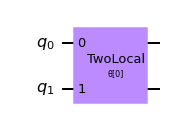

In [7]:
circuit_u = TwoLocal(
    n_molecular_orbitals,
    [],
    hop_gate,
    _entangler_map[structure][n_molecular_orbitals],
    reps=1,
)
ansatz = EntanglementForgingAnsatz(
    circuit_u=circuit_u,
    bitstrings_u=_bitstrings[structure][n_molecular_orbitals],
)

ansatz.circuit_u.draw("mpl")

### Set up the QiskitRuntimeService object

In [8]:
service_args = {
    "channel": "ibm_quantum",
    "token": "<YOUR_API_KEY>",
}
service = QiskitRuntimeService(**service_args)

### Specify an optimizer and set up the `EntanglementForgingGroundStateSolver`

In [9]:
optimizer = COBYLA()
backend_names = ["backend_name1", "backend_name2"]

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    backend_names=backend_names,
)

 ### Initialize Quantum Serverless in local mode. Set cluster one to enable all cores, since we will be doing a parallel quantum experiment.

In [10]:
serverless = QuantumServerless()

serverless.set_cluster(1)  # 0 -> single local core; 1 -> all local cores

QuantumServerless:
 | selected cluster: <Cluster: Local cluster (all cores)>

### Estimate the minimum eigenvalue of the system and also retrieve metadata from the optimization

In [11]:
%%capture

with serverless.context():
    ef_result = solver.solve(problem)

### Print the estimated ground state energy

In [12]:
e_ef = np.real(ef_result.groundenergy + ef_result.energy_shift)
print(f"E_EF = {e_ef} Ha")

E_EF = -3980.9955848927134 Ha


### Visualize the convergence of the ground state energy, Schmidt coefficients, and ansatz parameters.

Energy:


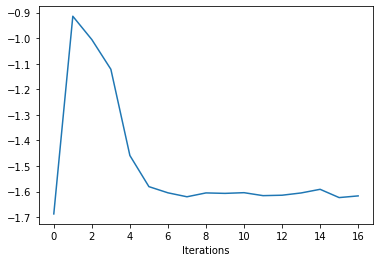

Schmidt Coefficients:


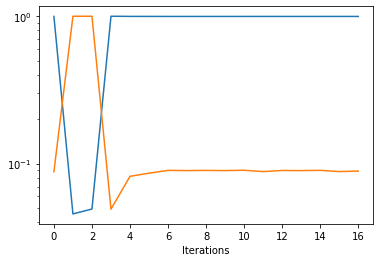

Parameters:


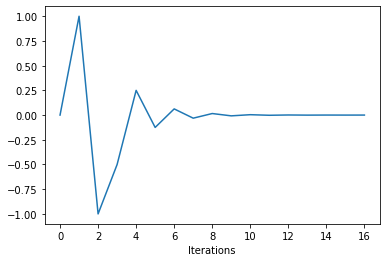

In [13]:
print("Energy:")
energies = [ef_result.history[i].eigenvalue for i in range(len(ef_result.history))]
plt.plot(energies)
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
schmidt_coeffs = [
    sorted(abs(ef_result.history[i].eigenstate)) for i in range(len(ef_result.history))
]
plt.plot(schmidt_coeffs)
plt.yscale("log")
plt.xlabel("Iterations")
plt.show()

print("Parameters:")
parameters = [ef_result.history[i].parameters for i in range(len(ef_result.history))]
plt.plot(parameters)
plt.xlabel("Iterations")
plt.show()